In [2]:
!git clone https://github.com/CVLAB-Unibo/ipcv-assignment-2.git

Cloning into 'ipcv-assignment-2'...
remote: Enumerating objects: 7371, done.
remote: Total 7371 (delta 0), reused 0 (delta 0), pack-reused 7371 (from 1)
Receiving objects: 100% (7371/7371), 753.77 MiB | 55.00 MiB/s, done.
Updating files: 100% (7396/7396), done.


In [3]:
from pathlib import Path
from PIL import Image
from torch import Tensor
from torch.utils.data import Dataset
from typing import List, Tuple

In [5]:
class OxfordPetDataset(Dataset):
    def __init__(self, split: str, transform=None) -> None:
        super().__init__()

        self.root = Path("ipcv-assignment-2") / "dataset"
        self.split = split
        self.names, self.labels = self._get_names_and_labels()
        self.transform = transform

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx) -> Tuple[Tensor, int]:
        img_path = self.root / "images" / f"{self.names[idx]}.jpg"
        img = Image.open(img_path).convert("RGB")
        label = self.labels[idx]
        
        if self.transform:
            img = self.transform(img)

        return img, label
    
    def get_num_classes(self) -> int:
        return max(self.labels) + 1

    def _get_names_and_labels(self) -> Tuple[List[str], List[int]]:
        names = []
        labels = []

        with open(self.root / "annotations" / f"{self.split}.txt") as f:
            for line in f:
                name, label = line.replace("\n", "").split(" ")
                names.append(name), 
                labels.append(int(label) - 1)

        return names, labels

In [6]:
import torch
import torchvision
from torchvision import transforms, utils
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from PIL import Image
import random
from collections import Counter


In [8]:

#trasformazione in un tensore pytorch e creazione di tre diversi split
#train, validation, test e stampo cosi so quanti ne ha ciascuno
to_tensor = transforms.ToTensor()

train_ds = OxfordPetDataset(split="train", transform=to_tensor)
val_ds   = OxfordPetDataset(split="val", transform=to_tensor)
test_ds  = OxfordPetDataset(split="test", transform=to_tensor)

print("Size train:", len(train_ds))
print("Size val:  ", len(val_ds))
print("Size test: ", len(test_ds))
num_classes = train_ds.get_num_classes()
print("Num classes:", num_classes)


Size train: 3669
Size val:   1834
Size test:  1846
Num classes: 37


In [9]:
def class_counts(dataset):
    return Counter(dataset.labels)

print("Train counts:", class_counts(train_ds))
# voglio visualizzare quante immagini ho per classe e queste sono cirac bilanciate 
#voglio visualizzare in ordine per capire benen  tutto 
counts = class_counts(train_ds)
labels_sorted = sorted(counts.items(), key=lambda x: x[0])
print(labels_sorted)


Train counts: Counter({1: 100, 2: 100, 3: 100, 4: 100, 5: 100, 6: 100, 9: 100, 10: 100, 12: 100, 13: 100, 14: 100, 15: 100, 16: 100, 17: 100, 19: 100, 20: 100, 21: 100, 22: 100, 23: 100, 24: 100, 25: 100, 26: 100, 27: 100, 28: 100, 29: 100, 31: 100, 32: 100, 33: 100, 35: 100, 36: 100, 8: 99, 18: 99, 30: 99, 0: 98, 11: 97, 34: 89, 7: 88})
[(0, 98), (1, 100), (2, 100), (3, 100), (4, 100), (5, 100), (6, 100), (7, 88), (8, 99), (9, 100), (10, 100), (11, 97), (12, 100), (13, 100), (14, 100), (15, 100), (16, 100), (17, 100), (18, 99), (19, 100), (20, 100), (21, 100), (22, 100), (23, 100), (24, 100), (25, 100), (26, 100), (27, 100), (28, 100), (29, 100), (30, 99), (31, 100), (32, 100), (33, 100), (34, 89), (35, 100), (36, 100)]


adesso voglio capire dato che ho 3.6 k che non è enorme per una CNN come mettere le augmentation che sono importanti per evitare overfitting e per avere minor differenza di immagini per ogni classe posso usare i psi nella crossentrpyloss e/o un weight random sampler.

In [13]:
#controllo la presenza di ogni label
labels = sorted(set(train_ds.labels))
print("Label min, max:", min(labels), max(labels))
print("Num unique labels:", len(labels))
print("Labels present:", labels)


Label min, max: 0 36
Num unique labels: 37
Labels present: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]


In [14]:
from collections import defaultdict
label_to_names = defaultdict(list)
for name, label in zip(train_ds.names, train_ds.labels):
    label_to_names[label].append(name)

#prime 3 immagini per ciascuna delle 5 classi per vedere esempio 
for lab in range(5):
    print(f"Label {lab} ({len(label_to_names[lab])} immagini): esempio nomi:", label_to_names[lab][:3])


Label 0 (98 immagini): esempio nomi: ['Abyssinian_201', 'Abyssinian_202', 'Abyssinian_204']
Label 1 (100 immagini): esempio nomi: ['american_bulldog_203', 'american_bulldog_205', 'american_bulldog_207']
Label 2 (100 immagini): esempio nomi: ['american_pit_bull_terrier_191', 'american_pit_bull_terrier_192', 'american_pit_bull_terrier_193']
Label 3 (100 immagini): esempio nomi: ['basset_hound_191', 'basset_hound_192', 'basset_hound_193']
Label 4 (100 immagini): esempio nomi: ['beagle_195', 'beagle_196', 'beagle_197']


mantengo le dimensioni e voglio visualizzare delle immagini del dataset 

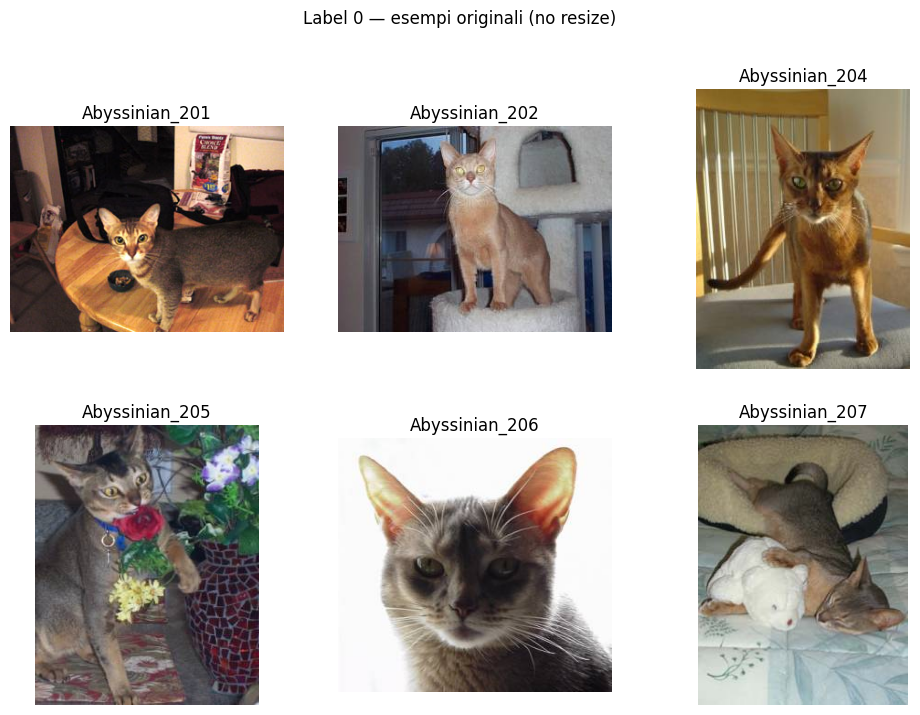

In [18]:
def show_examples_for_label_original(label, n=6, figsize=(12,8)):
    names = label_to_names[label][:n]
    plt.figure(figsize=figsize)
    for i, nm in enumerate(names):
        img = Image.open(train_ds.root / "images" / f"{nm}.jpg").convert("RGB")
        plt.subplot(2, 3, i+1)
        plt.imshow(img)
        plt.title(nm)
        plt.axis('off')
    plt.suptitle(f"Label {label} — esempi originali (no resize)")
    plt.show()
    
show_examples_for_label_original(0, n=6)


distribuzione di immagini per classe nel train 

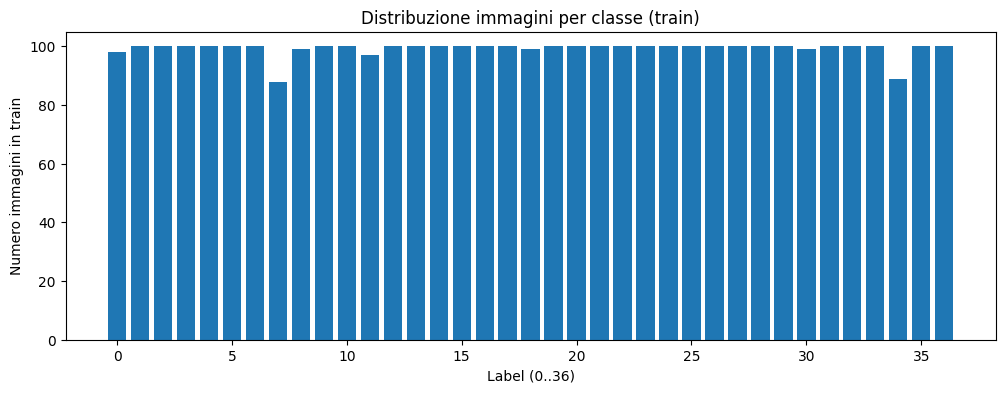

In [17]:

counts = [len(label_to_names[i]) for i in range(num_classes)]
plt.figure(figsize=(12,4))
plt.bar(range(num_classes), counts)
plt.xlabel("Label (0..36)")
plt.ylabel("Numero immagini in train")
plt.title("Distribuzione immagini per classe (train)")
plt.show()


Ogni immagine è un tensore di forma (3, H, W) con valori in [0,1] perche transforms.ToTensor() ha trasformato in tensori.
La media che rappresenta la luminosità media di ciascun canale (R, G, B) su tutto il training set.
La deviazione standard invece rappresenta quanto variano i valori di ciascun canale (il contrasto medio).
voglio normalizzare i dati con x norm che sarebbe x meno la media diviso la deviazione standard per poter avere i canali centrati inotrno a 0 e con varianza 1 
per calcolarli prima di tutto devo ridimensionare le immagini tutte con la stessa dimensione altrimenti ho un errore


In [25]:
#tutte le immagini della stessa dimensione
resize_to_tensor = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

#ricreare il dataset con temporanea misura nuova 
train_ds_tmp = OxfordPetDataset(split="train", transform=resize_to_tensor)

train_loader_tmp = DataLoader(train_ds_tmp, batch_size=64, shuffle=False, num_workers=2)

mean = 0.
std = 0.
nb_samples = 0.

for data, _ in train_loader_tmp:
    batch_samples = data.size(0)
    data = data.view(batch_samples, data.size(1), -1)  # (B, 3, H*W)
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
    nb_samples += batch_samples

mean /= nb_samples
std /= nb_samples

print("Mean:", mean)
print("Std:", std)


Mean: tensor([0.4845, 0.4529, 0.3959])
Std: tensor([0.2262, 0.2236, 0.2258])


adesso con mean e std che ho ricavato posso definrie le trasformazioni per addestramento della rete 

Train:

- Resize(256) → RandomResizedCrop(224) per ridimensionare e variare la porzione visibile dell’immagine

- RandomHorizontalFlip() e ColorJitter() per aumentare la varietà (data augmentation)

- ToTensor() per convertire in tensore

- Normalize() per normalizzare 

Validation / Test:

- Niente augmentation

- Resize(256) → CenterCrop(224) per mantenere la porzione centrale

- ToTensor() e Normalize()

In [26]:
from torchvision import transforms

mean_values = [0.4845, 0.4529, 0.3959]
std_values  = [0.2262, 0.2236, 0.2258]


train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_values, std=std_values)
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_values, std=std_values)
])

test_transform = val_transform


In [27]:
train_ds = OxfordPetDataset(split="train", transform=train_transform)
val_ds   = OxfordPetDataset(split="val", transform=val_transform)
test_ds  = OxfordPetDataset(split="test", transform=test_transform)

print("Train:", len(train_ds))
print("Val:", len(val_ds))
print("Test:", len(test_ds))
print("Classi:", train_ds.get_num_classes())


Train: 3669
Val: 1834
Test: 1846
Classi: 37


In [29]:

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=2)


In [30]:
imgs, labels = next(iter(train_loader))

print("Batch shape:", imgs.shape)    
print("Labels shape:", labels.shape)
print("Valori min:", imgs.min().item())
print("Valori max:", imgs.max().item())
print("Media per canale:", imgs.mean(dim=[0,2,3]))
print("Std per canale:", imgs.std(dim=[0,2,3]))

Batch shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32])
Valori min: -2.1419098377227783
Valori max: 2.6753764152526855
Media per canale: tensor([-0.0486, -0.1143, -0.0529])
Std per canale: tensor([1.0626, 1.0821, 1.0788])


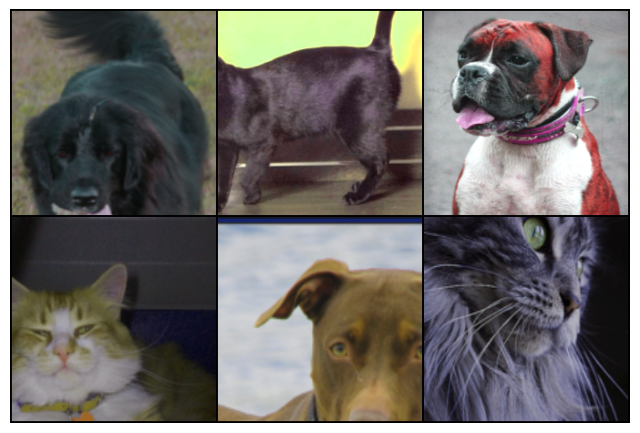

In [31]:

def show_batch(imgs, mean, std, n=6):
    mean = torch.tensor(mean).view(3,1,1)
    std = torch.tensor(std).view(3,1,1)
    imgs = imgs[:n] * std + mean  # denormalizza
    imgs = torch.clamp(imgs, 0, 1)
    grid = transforms.ToPILImage()(torchvision.utils.make_grid(imgs, nrow=3))
    plt.figure(figsize=(8,6))
    plt.imshow(grid)
    plt.axis("off")
    plt.show()

show_batch(imgs, mean_values, std_values, n=6)


In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PetNet(nn.Module):
    def __init__(self, num_classes=37):
        super().__init__()

        # --- Feature extractor ---
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)   # -> 32 x 112 x 112
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)   # -> 64 x 56 x 56
        )

        self.conv_block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)   # -> 128 x 28 x 28
        )

        # --- Classifier ---
        self.fc1 = nn.Linear(128 * 28 * 28, 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = torch.flatten(x, 1)  # (batch, features)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [35]:
model = PetNet(num_classes=train_ds.get_num_classes())
x = torch.randn(4, 3, 224, 224)
out = model(x)
print("Output shape:", out.shape)


Output shape: torch.Size([4, 37])


In [36]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

model = PetNet(num_classes=37).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


Device: cuda


In [38]:
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for imgs, labels in dataloader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        _, preds = outputs.max(1)
        total += labels.size(0)
        correct += preds.eq(labels).sum().item()

    return running_loss / total, correct / total


def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * imgs.size(0)
            _, preds = outputs.max(1)
            total += labels.size(0)
            correct += preds.eq(labels).sum().item()

    return running_loss / total, correct / total


In [40]:
num_epochs = 5

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
    print(f"  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc*100:.2f}%")


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7aa74013ba60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7aa74013ba60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 1/5:
  Train Loss: 3.6125 | Train Acc: 2.64%
  Val Loss:   3.6116 | Val Acc:   2.73%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7aa74013ba60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7aa74013ba60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 2/5:
  Train Loss: 3.6120 | Train Acc: 2.37%
  Val Loss:   3.6114 | Val Acc:   2.73%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7aa74013ba60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7aa74013ba60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 3/5:
  Train Loss: 3.6118 | Train Acc: 2.73%
  Val Loss:   3.6112 | Val Acc:   2.73%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7aa74013ba60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()Exception ignored in: 
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7aa74013ba60>
    Traceback (most recent call last):
if w.is_alive():  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__

      self._shutdown_workers() 
    File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
      if w.is_alive():^
^^ ^^  ^^ ^ ^ ^ ^^^^
^^  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^    assert self._parent_pid == os.getpid(), 'can only test a child process'^^
^ ^ ^ ^ ^ 
   File "/usr/lib/

Epoch 4/5:
  Train Loss: 3.6118 | Train Acc: 2.23%
  Val Loss:   3.6111 | Val Acc:   2.67%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7aa74013ba60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7aa74013ba60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 5/5:
  Train Loss: 3.6115 | Train Acc: 2.62%
  Val Loss:   3.6111 | Val Acc:   2.73%


Img tensor stats: -0.6897648572921753 1.0988773107528687


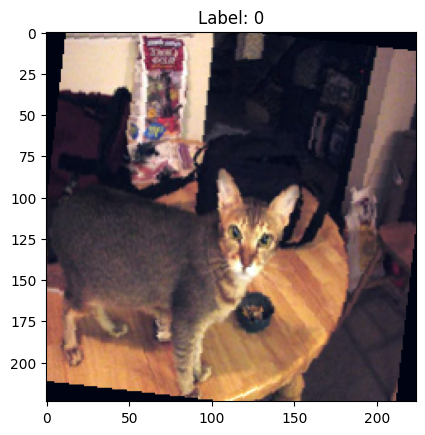

In [138]:
import matplotlib.pyplot as plt
img, label = train_dataset[0]
print("Img tensor stats:", img.mean().item(), img.std().item())
plt.imshow(img.permute(1, 2, 0).cpu() * 0.229 + 0.485)  # denormalizza
plt.title(f"Label: {label}")
plt.show()


In [139]:
from torchvision import transforms
from torch.utils.data import DataLoader

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


train_dataset = OxfordPetDataset(split="train", transform=train_transform)
val_dataset = OxfordPetDataset(split="val", transform=val_test_transform)
test_dataset = OxfordPetDataset(split="test", transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)


Img tensor stats: -0.6126033067703247 1.097931146621704


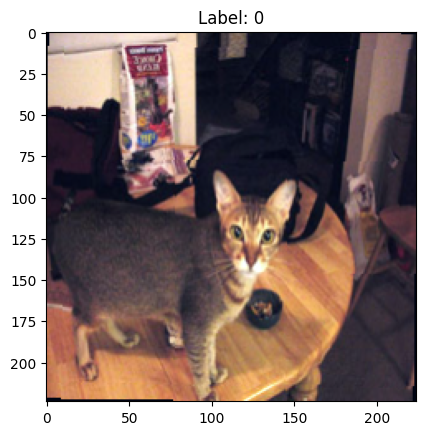

In [140]:
import matplotlib.pyplot as plt
img, label = train_dataset[0]
print("Img tensor stats:", img.mean().item(), img.std().item())
plt.imshow(img.permute(1, 2, 0).cpu() * 0.229 + 0.485)  # denormalizza
plt.title(f"Label: {label}")
plt.show()


In [141]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from pathlib import Path
from PIL import Image


In [142]:
import torch.nn as nn
import torch

class DeepCNN(nn.Module):
    def __init__(self, num_classes, use_batchnorm=False, use_dropout=True):
        super().__init__()
        layers = []
        in_channels = 3
        channels_list = [32, 64, 128, 256]

        for out_channels in channels_list:
            layers.append(nn.Conv2d(in_channels, out_channels, 3, padding=1))
            if use_batchnorm:
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.ReLU())
            layers.append(nn.MaxPool2d(2))
            in_channels = out_channels
        
        self.features = nn.Sequential(*layers)
        
        final_size = 224
        for _ in channels_list:
            final_size //= 2  # 5 pool 2x2 → 224 → 112 → 56 → 28 → 14 → 7
        
        classifier_layers = [
            nn.Flatten(),
            nn.Linear(in_channels * final_size * final_size, 512),
            nn.ReLU()
        ]
        if use_dropout:
            classifier_layers.append(nn.Dropout(0.5))
        classifier_layers.append(nn.Linear(512, num_classes))
        self.classifier = nn.Sequential(*classifier_layers)
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

num_classes = train_dataset.get_num_classes()
model = DeepCNN(num_classes=num_classes)


In [155]:
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)

model.apply(init_weights)





device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


DeepCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=50176, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=512, out_features=37, bias=True)
  )
)

In [156]:
imgs, _ = next(iter(train_loader))
imgs = imgs.to(device)
with torch.no_grad():
    out = model.features(imgs)
print("Mean:", out.mean().item(), "Std:", out.std().item())


Mean: 1.3503831624984741 Std: 1.7227643728256226


In [157]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)


In [158]:
subset = torch.utils.data.Subset(train_dataset, range(200))
small_loader = DataLoader(subset, batch_size=8, shuffle=True)

for epoch in range(10):
    model.train()
    loss_sum = 0
    for imgs, labels in small_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
        optimizer.step()
        loss_sum += loss.item()
    print(f"Epoch {epoch+1}, Loss: {loss_sum/len(small_loader):.4f}")


Epoch 1, Loss: 2.5307
Epoch 2, Loss: 1.3092
Epoch 3, Loss: 0.8480
Epoch 4, Loss: 1.1663
Epoch 5, Loss: 0.8680
Epoch 6, Loss: 0.8614
Epoch 7, Loss: 0.6939
Epoch 8, Loss: 0.7064
Epoch 9, Loss: 0.5132
Epoch 10, Loss: 0.6400


In [159]:
model = DeepCNN(num_classes, use_batchnorm=False).to(device)
model.apply(init_weights)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)


In [160]:
imgs, labels = next(iter(train_loader))
imgs, labels = imgs.to(device), labels.to(device)
outputs = model(imgs)
print("Output shape:", outputs.shape)
print("Output mean:", outputs.mean().item(), "std:", outputs.std().item())
print("Label min/max:", labels.min().item(), labels.max().item())


Output shape: torch.Size([64, 37])
Output mean: 0.5239895582199097 std: 4.433313846588135
Label min/max: 0 36


In [149]:
# 🔧 Parametri aggiornati
num_epochs = 15
train_losses = []
val_accuracies = []

# 1️⃣ Ottimizzatore + scheduler più stabili
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

# 2️⃣ Ciclo di training
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        
        # Gradient clipping per stabilità
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
        optimizer.step()
        
        running_loss += loss.item()
    
    # 3️⃣ Media loss per epoca
    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)

    # 4️⃣ Validazione
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    
    val_acc = correct / total
    val_accuracies.append(val_acc)
    
    # 5️⃣ Scheduler
    scheduler.step(avg_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Val Accuracy: {val_acc:.4f}")


Epoch 1/15, Loss: 4.2845, Val Accuracy: 0.0344
Epoch 2/15, Loss: 3.6090, Val Accuracy: 0.0393
Epoch 3/15, Loss: 3.6024, Val Accuracy: 0.0436
Epoch 4/15, Loss: 3.5881, Val Accuracy: 0.0474
Epoch 5/15, Loss: 3.5830, Val Accuracy: 0.0420


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(val_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    return correct / total

val_acc = evaluate(model, val_loader)
test_acc = evaluate(model, test_loader)
print(f"Validation Accuracy: {val_acc:.4f}, Test Accuracy: {test_acc:.4f}")


In [ ]:
class AblationCNN(nn.Module):
    def __init__(self, num_classes, depth=5, use_batchnorm=True, use_dropout=True):
        super().__init__()
        layers = []
        in_channels = 3
        channels_list = [32, 64, 128, 256, 512]  # massimo 5 blocchi

        for i in range(depth):
            out_channels = channels_list[i]
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
            if use_batchnorm:
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.ReLU())
            layers.append(nn.MaxPool2d(2))
            in_channels = out_channels
        
        self.features = nn.Sequential(*layers)
        
        # calcoliamo la dimensione del feature map finale
        final_size = 224
        for _ in range(depth):
            final_size //= 2
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_channels * final_size * final_size, 512),
            nn.ReLU(),
        )
        if use_dropout:
            self.classifier.add_module("dropout", nn.Dropout(0.5))
        self.classifier.add_module("output", nn.Linear(512, num_classes))
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [ ]:
configs = [
    {"name": "Full Model", "depth":5, "use_batchnorm":True, "use_dropout":True},
    {"name": "No Dropout", "depth":5, "use_batchnorm":True, "use_dropout":False},
    {"name": "No BatchNorm", "depth":5, "use_batchnorm":False, "use_dropout":True},
    {"name": "Shallow 3 layers", "depth":3, "use_batchnorm":True, "use_dropout":True},
    {"name": "No Augmentation", "depth":5, "use_batchnorm":True, "use_dropout":True, "augment":False}
]


In [ ]:
def train_model(config, train_loader, val_loader, num_classes, device, epochs=10):
    model = AblationCNN(num_classes=num_classes,
                        depth=config.get("depth",5),
                        use_batchnorm=config.get("use_batchnorm",True),
                        use_dropout=config.get("use_dropout",True))
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"{config['name']} - Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")
    
    acc = evaluate(model, val_loader)
    print(f"{config['name']} - Validation Accuracy: {acc:.4f}")
    return acc


In [ ]:
results = {}
for cfg in configs:
    acc = train_model(cfg, train_loader, val_loader, num_classes, device, epochs=10)
    results[cfg['name']] = acc

# Mostrare i risultati in tabella
import pandas as pd
df = pd.DataFrame(list(results.items()), columns=["Model Variant", "Validation Accuracy"])
print(df)


In [ ]:
import matplotlib.pyplot as plt

# Esempio: df contiene già i risultati della validation accuracy
# df = pd.DataFrame(list(results.items()), columns=["Model Variant", "Validation Accuracy"])

plt.figure(figsize=(10,6))
plt.bar(df["Model Variant"], df["Validation Accuracy"], color='skyblue')
plt.ylim(0, 1)
plt.ylabel("Validation Accuracy")
plt.title("Ablation Study - Effect of Model Components")
plt.xticks(rotation=45, ha='right')

# Aggiungiamo le etichette sopra ogni barra
for i, v in enumerate(df["Validation Accuracy"]):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center', fontweight='bold')

plt.tight_layout()
plt.show()


In [ ]:
def train_model_tracking(config, train_loader, val_loader, num_classes, device, epochs=10):
    model = AblationCNN(num_classes=num_classes,
                        depth=config.get("depth",5),
                        use_batchnorm=config.get("use_batchnorm",True),
                        use_dropout=config.get("use_dropout",True))
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    train_losses = []
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)
        print(f"{config['name']} - Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")
    
    val_acc = evaluate(model, val_loader)
    print(f"{config['name']} - Validation Accuracy: {val_acc:.4f}")
    
    return train_losses, val_acc


In [ ]:
history = {}

for cfg in configs:
    losses, acc = train_model_tracking(cfg, train_loader, val_loader, num_classes, device, epochs=10)
    history[cfg['name']] = {"train_loss": losses, "val_acc": acc}


In [ ]:
plt.figure(figsize=(12,6))

# Plot training loss per variante
for name, data in history.items():
    plt.plot(data["train_loss"], label=f"{name} - Loss")
    
# Plot validation accuracy come punti finali
for i, (name, data) in enumerate(history.items()):
    plt.scatter(len(data["train_loss"])-1, data["val_acc"], label=f"{name} - Val Acc", s=100)

plt.xlabel("Epoch")
plt.ylabel("Loss / Validation Accuracy")
plt.title("Training Loss and Validation Accuracy per Model Variant")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
